In [41]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [67]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde
from scipy.integrate import quad

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=False)

### Training and auxiliary Functions

In [68]:
def cfi(state_gen_func, state_gen_args, p, povm, n_copies=1, n_ext=0, dp=1e-5):
    dm = reduce(kron, [state_gen_func(p, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_m = reduce(kron, [state_gen_func(p - dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 0
    for op in povm:
        prob = trace(dot(dm, op)).real
        if prob > 0:
            prob_p = trace(dot(dm_p, op)).real
            prob_m = trace(dot(dm_m, op)).real
            der = (prob_p - prob_m)/(2*dp)
            fi += der**2/prob
    return fi

def qfi(state_gen_func, state_gen_args, p, n_copies=1, n_ext=0, dp=1e-2):
    dm = reduce(kron, [state_gen_func(p, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 8*(1 - sqrt(fidelity(dm, dm_p))) / dp**2
    return fi

def qfi_central(state_gen_func, state_gen_args, p, n_copies=1, n_ext=0, dp=1e-2):
    dm_p = reduce(kron, [state_gen_func(p + dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    dm_m = reduce(kron, [state_gen_func(p - dp, *state_gen_args)]*n_copies + [diag([1] + [0]*(2**(n_ext) - 1))])
    fi = 8*(1 - sqrt(fidelity(dm_m, dm_p))) / dp**2/4
    return fi

In [69]:
def train_bayes(n_inp, n_layers, a, b, state_gen_func, prior_func, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, method="BFGS", x0=None, options={}):

    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    
    d_diff = 0 if n_tot == n_meas else 2**(n_tot - n_meas)
    
    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]

    def fun_int(phi, x_est, U):
        dm = state_gen_func(phi, *state_gen_args)
        dm = reduce(kron, [dm]*n_copies)
        dm_u = U@dm@U.conj().T
        probs = dm_u.diagonal().real
        return np.sum((x_est - phi)**2*probs*prior_func(phi, *prior_args))

    # def fun_int(phi, x_est, U):
    #     dm = state_gen_func(phi, *state_gen_args)
    #     dm = reduce(kron, [dm]*n_copies)
    #     dm_u = U@dm@U.conj().T
    #     H = diag(x_est) - phi*eye(d)
    #     H = H@H
    #     return prior_func(phi, *prior_args)*trace(dm_u@H).real
    
    fvals = []
    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        f = quad(fun_int, a, b, args=(x_est, U))[0]
        fval_cont[0] = f
        return f
        
    def callback(x):
        fvals.append(fval_cont[0])
        print("Iteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

In [70]:
def aux_info(channel_func, channel_pars, channel_args, dm_ini, pars, n_layers, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_inp = int(log2(len(dm_ini)))
    n_tot = n_inp*n_copies

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_n = []
    dms_n_p = []
    dms_n_m = []
    for p in channel_pars:
        dm_n = reduce(kron, [channel_func(dm_ini, p, *channel_args)]*n_copies)
        dm_n_p = reduce(kron, [channel_func(dm_ini, p+dp, *channel_args)]*n_copies)
        dm_n_m = reduce(kron, [channel_func(dm_ini, p-dp, *channel_args)]*n_copies)
        dms_n.append(dm_n)
        dms_n_p.append(dm_n_p)
        dms_n_m.append(dm_n_m)

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(channel_pars)): # take a density matrix from the training set
        probs = [trace(dms_n[j]@proj).real for proj in projs_u]
        probs_der = [trace((dms_n_p[j] - dms_n_m[j])@proj).real/(2*dp) for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        QFI = 2*(1 - sqrt(fidelity(dms_n_m[j], dms_n_p[j]))) / dp**2 + 1e-10 # via centered differences 
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
        QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [71]:
def aux_info_bayes(n_inp, pars, a, b, state_gen_func, prior_func, n_layers, labels, state_gen_args=[], prior_args=[], n_copies=1, n_meas=0, dp=1e-5):

    n_tot = n_inp*n_copies
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [U.conj().T@proj@U for proj in projs]
    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    H_sq = H@H

#     def func_F(phi):
#         CFI = cfi(state_gen_func, state_gen_args, phi, projs_u, n_copies=n_copies, n_ext=0, dp=dp)
#         return CFI*prior_func(phi, *prior_args)
#     def func_I(phi):
#         prior_der = (prior_func(phi + dp, *prior_args) - prior_func(phi - dp, *prior_args))/(2*dp)
#         return prior_der**2/prior_func(phi, *prior_args)
#     def func_dphi(phi):
#         return prior_func(phi, *prior_args)*phi**2
#     def func_QBI(phi):
#         dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies)
#         return prior_func(phi, *prior_args)*trace(H_sq@dm).real
    
#     int_F = quad(func_F, a, b)[0]
#     int_I = quad(func_I, a, b)[0]
#     CRB = 1/(int_F + int_I)
#     QCRB = quad(func_F, a, b)[0] - quad(func_QBI, a, b)[0]

    dms = []
    dms_der = []
    for phi in labels:
        dm = reduce(kron, [state_gen_func(phi, *state_gen_args)]*n_copies)
        dm_p = reduce(kron, [state_gen_func(phi + dp, *state_gen_args)]*n_copies)
        dm_m = reduce(kron, [state_gen_func(phi - dp, *state_gen_args)]*n_copies)
        dm_der = (dm_p - dm_m)/(2*dp)
        dms.append(dm)
        dms_der.append(dm_der)

    expecs = []
    expecs_der = []
    disps = []
    for j in range(len(labels)): # take a density matrix from the training set
        probs = [trace(dms[j]@proj).real for proj in projs_u]
        probs_der = [trace(dms_der[j]@proj).real for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
    
    return array(expecs), array(expecs_der), array(disps), #QCRBCRB, QCRB#, int_F, int_I, H

## 1. Theoretical Observables $H$

In [72]:
# channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
# channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

In [73]:
I

array([[1., 0.],
       [0., 1.]])

In [74]:
def Hm_dep(k):
    dm_ini = (eye(2) + X)/2
    return (10+3*k)/(3*(k+5))*I-k/(k+5)*X
def rho_dep(a):
    dm_ini = (eye(2) + X)/2
    return (1-a)*dm_ini+a*I/2
def Drho_dep(a):
    dm_ini = (eye(2) + X)/2
    return -dm_ini+I/2
#rho(2)@Hm(1)
def disp_dep(a, k):
    return trace(rho_dep(a)@Hm_dep(k)@Hm_dep(k))-(trace(rho_dep(a)@Hm_dep(k)))**2
def DrhoH_dep(a,k):
    return trace(Drho_dep(a)@Hm_dep(k))**2
disp_dep(1, 100)

0.9070294784580499

In [10]:
10/81

0.12345679012345678

The Inequality:

$RHS=LHS=10/81\approx 0.12345679012345678$

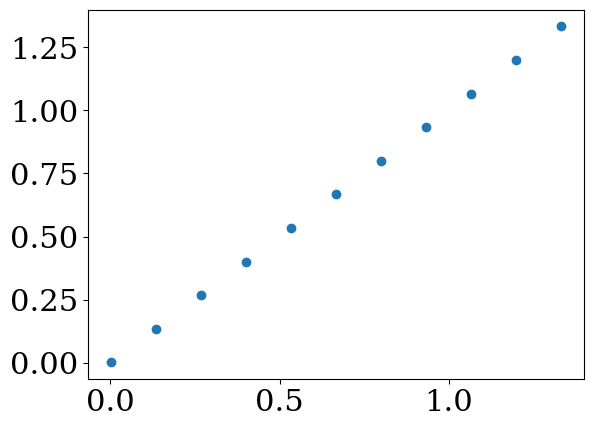

In [11]:
a = 1e-3
b = 4/3 - 1e-3
#a=0.0
#b=1.0- 1e-3
labels_train = linspace(a, b, 11)#[1:-1]
#labels_train = np.sort(uniform(a, b, 5))
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 15)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)

In [12]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-5

x0 = None#concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
               w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars = result.x
#print(pars)
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(channel_func, labels_train, 
                                                                               channel_args, dm_ini, pars, n_layers,
                                                                               n_copies=n_copies, n_meas=n_meas, dp=dp)

print("\n", result.message)

Iteration: 120 | Function value: 0.00078249
 Optimization terminated successfully.


In [13]:
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, 
                                                                          channel_args, dm_ini, pars, n_layers,
                                                                          n_copies=n_copies, n_meas=n_meas, dp=dp)

Cost: 0.0007824942780211185

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 2.7081753255041976e-08


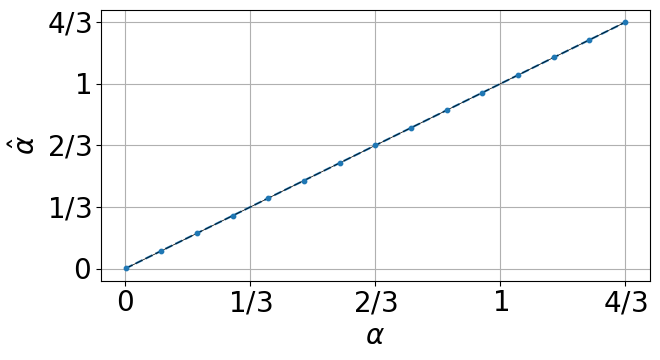

Sum var: 0.7195075469155746
Sum difference: 0.0009662365168266352
Least squares: 1.3855052582656074e-05


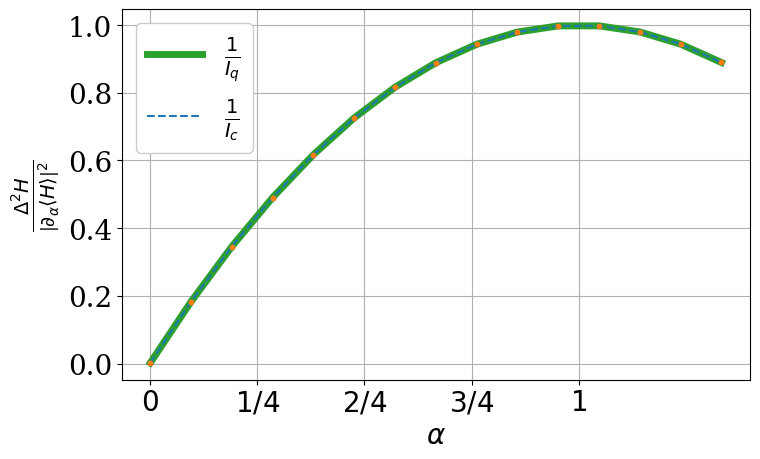

In [14]:
print("Cost:", result.fun)
print("\nn_copies: %d | n_meas: %d | n_layers: %d" %(n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nSum error:", sum(np.abs(labels_test - expecs_test)**2)/len(CFIs_test))

matplotlib.rcParams.update({'font.size': 20})
#expecs_theory
plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=10, zorder=10)
plt.plot(labels_test, [trace(rho_dep(a)@Hm_dep(w_ls/w_var)) for a in labels_test], linestyle="dashed") ### Theory
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
#plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel
#plt.yticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel

plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


print("Sum var:", n_copies*sum(disps_test)/len(CFIs_test))
print("Sum difference:", sum(np.abs(CFIs_test - QFIs_test))/len(CFIs_test))
print("Least squares:", sum((CFIs_test - QFIs_test)**2)/len(CFIs_test))

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=10, zorder=10)
plt.scatter(labels_test, n_copies*[disp_dep(a, w_ls/w_var)/DrhoH_dep(a,w_ls/w_var) for a in labels_test], s=10, zorder=10)
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), n_copies/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
#plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1$"])
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

### Amplitude Damping Channel

In [75]:
def Hm_ADI(k):
    return 4/(k+8)*I+k/(k+8)*Z
def rho_ADI(a):
    return np.array([[(1+a)/2, 0],[0, (1-a)/2]])
def Drho_ADI(a):
    return np.array([[1/2, 0], [0, -1/2]])
#rho(2)@Hm(1)
def disp_ADI(a, k):
    return trace(rho_ADI(a)@Hm_ADI(k)@Hm_ADI(k))-(trace(rho_ADI(a)@Hm_ADI(k)))**2
def DrhoH_ADI(a,k):
    return trace(Drho_ADI(a)@Hm_ADI(k))**2
disp_ADI(0.5, 10)

0.2314814814814815

In [16]:
2/27

0.07407407407407407

The Inequality:

$RHS=LHS=2/27\approx 0.07407407407407407$

## 2. Bayes Training and Final Plots

In [5]:
def zrot_state_gen(p, dm, tq):
    n_qubits = int(log2(len(dm)))
    dl = 2**tq
    dr = 2**(n_qubits - tq - 1)
    U = reduce(kron, [eye(dl), expm(-1j*p/2*Z), eye(dr)]) # inefficient
    return U@dm@U.conj().T


In [6]:
def depolarizing_channel_gen(p, dm):
    d = len(dm)
    return (1 - p)*dm + p/d*eye(d)

In [9]:
def generalized_amplitude_damping_channel_gen(g,dm, N, target_qubit):
    
    n_qubits = int(log2(len(dm)))
    dl = 2**target_qubit
    dr = 2**(n_qubits - target_qubit - 1)
    
    K1 = array([[1,           0],
                [0, sqrt(1 - g)]])*sqrt(1 - N)
    K1 = reduce(kron, [eye(dl), K1, eye(dr)]) # inefficient
    
    K2 = array([[0, sqrt(g*(1 - N))],
                [0,               0]])
    K2 = reduce(kron, [eye(dl), K2, eye(dr)])
    
    K3 = array([[sqrt(1 - g), 0],
                [          0, 1]])*sqrt(N)
    K3 = reduce(kron, [eye(dl), K3, eye(dr)])
            
    K4 = array([[0,         0],
                [sqrt(g*N), 0]])
    K4 = reduce(kron, [eye(dl), K4, eye(dr)])
    
    dm1 = reduce(dot, [K1, dm, K1.conj().T])
    dm2 = reduce(dot, [K2, dm, K2.conj().T])
    dm3 = reduce(dot, [K3, dm, K3.conj().T])
    dm4 = reduce(dot, [K4, dm, K4.conj().T])
        
    return dm1 + dm2 + dm3 + dm4

### 2.1 Depolarizing channel

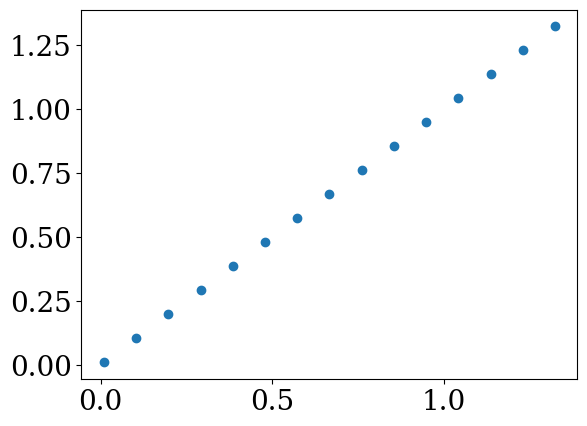

In [107]:
#channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"
state_gen_func = depolarizing_channel_gen
dm_inp = (I + X)/2
tq = 0
state_gen_args = [dm_inp]

a = 0 + 0
b = 4/3 - 0
T = 15

eps = 1e-2
labels = linspace(a + eps, b - eps, T)#[1:-1]
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]
dms = [state_gen_func(p, *state_gen_args) for p in labels]

plt.scatter(labels, labels)

In [108]:
n_inp = int(log2(len(dm_inp)))
method = "BFGS"

In [109]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_layers_1 = 1

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies_1 - 1)*n_layers_1 + 2*n_inp*n_copies_1), normal(0., 1, 2**n_meas_1)])

fvals_1, result_1 = train_bayes(n_inp, n_layers_1, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies_1, n_meas=n_meas_1, method=method, x0=x0, options={})
pars_1 = result_1.x

print("\n", result_1.message)

Iteration: 13 | Function value: 0.12345679
 Optimization terminated successfully.


In [110]:
fval_dep=fvals_1[-1]
print("From Inequality:           ", 10/81)
print("From Bayes function value: ", 0.12345679)

From Inequality:            0.12345679012345678
From Bayes function value:  0.12345679


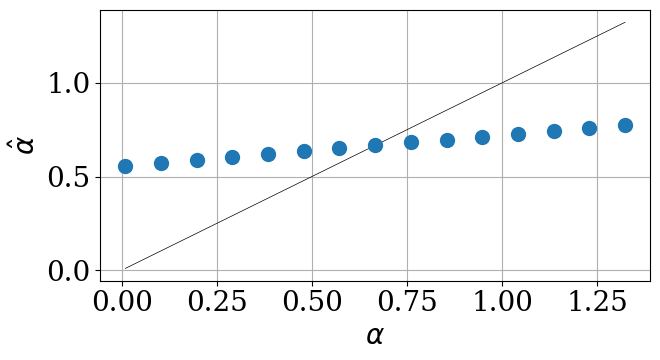

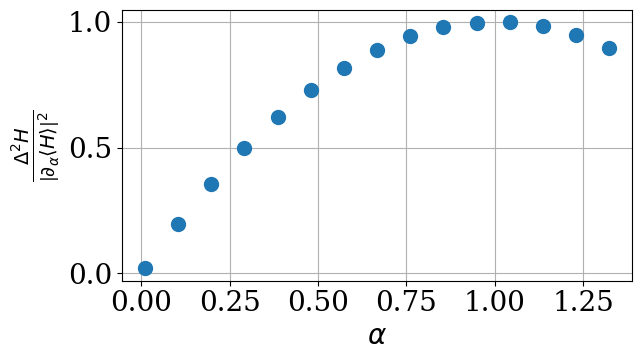

In [111]:
eps = 0.1
dp = 1e-7

expecs_1, expecs_der_1, disps_1 = aux_info_bayes(n_inp, pars_1, a+eps, b-eps, state_gen_func=state_gen_func, prior_func=prior_func, n_layers=n_layers_1, labels=labels,state_gen_args=state_gen_args, prior_args =prior_args, n_copies=n_copies_1, n_meas=n_meas_1, dp=dp)

#expecs_1, expecs_der_1, disps_1, CRB_1, QCRB_1 = aux_info_bayes(n_inp, pars_1, a+eps, b-eps, state_gen_func=state_gen_func, prior_func=prior_func, n_layers=n_layers_1, labels=labels,state_gen_args=state_gen_args, prior_args =prior_args, n_copies=n_copies_1, n_meas=n_meas_1, dp=dp)
# expecs_2, expecs_der_2, disps_2, CRB_2, QCRB_2 = aux_info(n_inp, pars_2, a+eps, b-eps, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_2, labels=labels, n_copies=n_copies_2, n_meas=n_meas_2, dp=dp)

# expecs_1, expecs_der_1, disps_1 = aux_info_uni_1c(pars_1, n_layers_1, labels)
# expecs_2, expecs_der_2, disps_2 = aux_info_uni_2c(pars_2, n_layers_2, labels)

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_1, s=100, zorder=10)
#plt.scatter(labels, expecs_2, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

#print(sum(2*disps_2/expecs_der_2**2))

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_1/expecs_der_1**2, s=100, zorder=10)
#plt.scatter(labels, 2*disps_2/expecs_der_2**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
#plt.plot(labels, [1]*T, color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=2)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

### 2.2 Plotting the Fiinal graphs for Depolarizing channel:

			Iteration: 98 | Cost: 0.00078249 | Time passed: 0 s
 Optimization terminated successfully.
Cost: 0.0007824942766299973

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 2.7222269880075435e-08


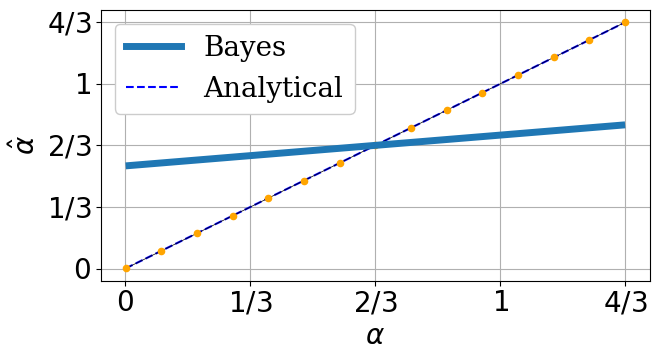

Sum var: 0.7195060527865473
Sum difference: 0.0007954068636094233
Least squares: 9.374944000050232e-06


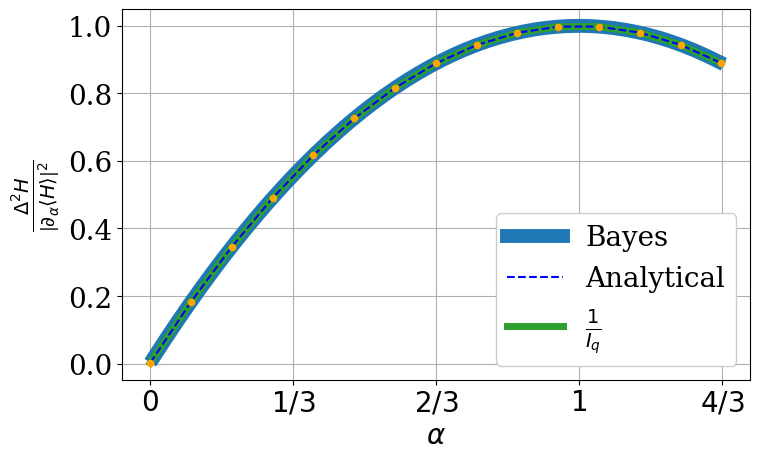

From Inequality:            0.12345679012345678
From Bayes function value:  0.12345679


In [100]:
channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

dm_ini = (eye(2) + X)/2
a = 1e-3
b = 4/3 - 1e-3
labels_train = linspace(a, b, 11)#[1:-1]

dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 15)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-5

x0 = None#concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
               w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars = result.x
#print(pars)
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(channel_func, labels_train, 
                                                                               channel_args, dm_ini, pars, n_layers,
                                                                               n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, 
                                                                          channel_args, dm_ini, pars, n_layers,
                                                                          n_copies=n_copies, n_meas=n_meas, dp=dp)
print("\n", result.message)
print("Cost:", result.fun)
print("\nn_copies: %d | n_meas: %d | n_layers: %d" %(n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nSum error:", sum(np.abs(labels_test - expecs_test)**2)/len(CFIs_test))

matplotlib.rcParams.update({'font.size': 20})

#expecs_theory
plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=20, zorder=10, color="orange")
plt.plot(labels, expecs_1, zorder=10,linewidth=5, label="Bayes")
plt.plot(labels_test, [trace(rho_dep(a)@Hm_dep(w_ls/w_var)) for a in labels_test], linestyle="dashed", label="Analytical", color="blue") ### Theory
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.legend(framealpha=1)
#plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel
#plt.yticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel

plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


print("Sum var:", n_copies*sum(disps_test)/len(CFIs_test))
print("Sum difference:", sum(np.abs(CFIs_test - QFIs_test))/len(CFIs_test))
print("Least squares:", sum((CFIs_test - QFIs_test)**2)/len(CFIs_test))

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=20, zorder=12, color="orange")
plt.plot(labels, disps_1/expecs_der_1**2, linewidth=10, zorder=9, label="Bayes")
plt.plot(labels_test, n_copies*[disp_dep(a, w_ls/w_var)/DrhoH_dep(a,w_ls/w_var) for a in labels_test], color="blue", linestyle="dashed", zorder=11, label="Analytical")
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid", zorder=10) # , color="tab:blue"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
#plt.plot(np.sort(labels_test), n_copies/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
#plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1$"])
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

print("From Inequality:           ", 10/81)
print("From Bayes function value: ", 0.12345679)

In [26]:
fval_dep

0.12345679012654245

# 2.3 Amplitude Damping

## Maximally mixed input

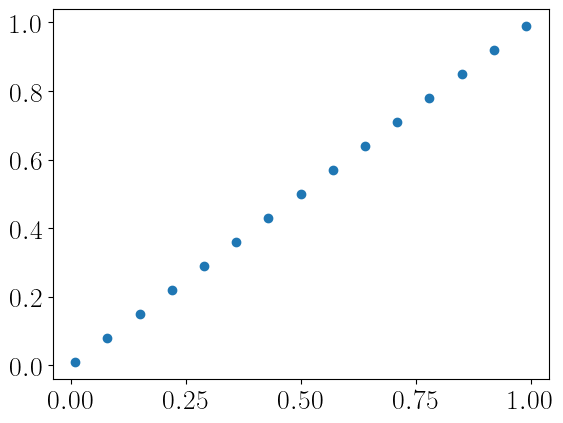

In [48]:
#channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"
channel_func = generalized_amplitude_damping_channel;
state_gen_func = generalized_amplitude_damping_channel_gen
channel_args = [0, 0]; channel_name = "ad"
dm_ini = eye(2)/2
dm_inp = I/2
tq = 0
state_gen_args = [dm_inp, 0, 0]

a = 0 + 0
b = 1 - 0
T = 15

eps = 1e-2
labels = linspace(a + eps, b - eps, T)#[1:-1]
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels]
dms = [state_gen_func(p, *state_gen_args) for p in labels]

plt.scatter(labels, labels)

In [49]:
n_inp = int(log2(len(dm_inp)))
method = "BFGS"
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_layers_1 = 1

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies_1 - 1)*n_layers_1 + 2*n_inp*n_copies_1), normal(0., 1, 2**n_meas_1)])

fvals_1, result_1 = train_bayes(n_inp, n_layers_1, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies_1, n_meas=n_meas_1, method=method, x0=x0, options={})
pars_1 = result_1.x

print("\n", result_1.message)

Iteration: 18 | Function value: 0.07407407
 Optimization terminated successfully.


In [50]:
fval_AD=fvals_1[-1]
print("From Inequality:           ", 2/27)
print("From Bayes function value: ", fval_AD)

From Inequality:            0.07407407407407407
From Bayes function value:  0.07407407436886235


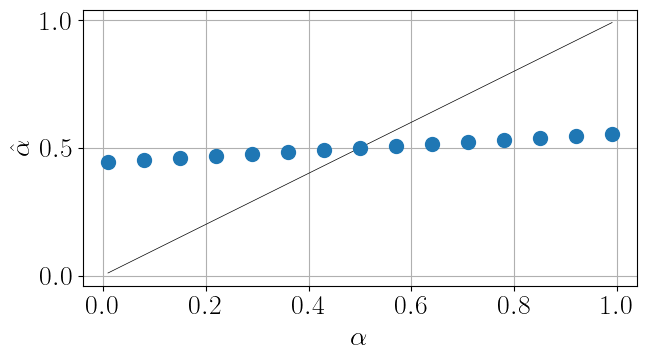

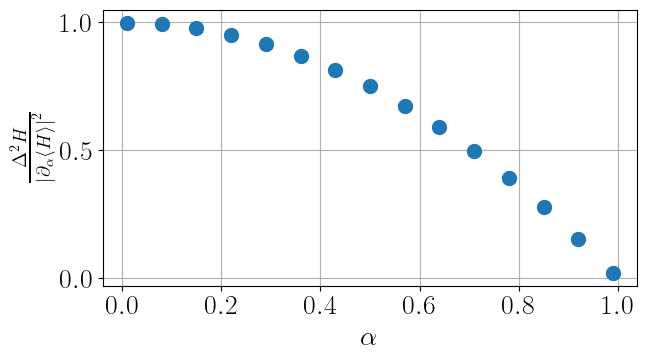

In [51]:
eps = 0.1
dp = 1e-7

expecs_1, expecs_der_1, disps_1 = aux_info_bayes(n_inp, pars_1, a+eps, b-eps, state_gen_func=state_gen_func, prior_func=prior_func, n_layers=n_layers_1, labels=labels,state_gen_args=state_gen_args, prior_args =prior_args, n_copies=n_copies_1, n_meas=n_meas_1, dp=dp)

#expecs_1, expecs_der_1, disps_1, CRB_1, QCRB_1 = aux_info_bayes(n_inp, pars_1, a+eps, b-eps, state_gen_func=state_gen_func, prior_func=prior_func, n_layers=n_layers_1, labels=labels,state_gen_args=state_gen_args, prior_args =prior_args, n_copies=n_copies_1, n_meas=n_meas_1, dp=dp)
# expecs_2, expecs_der_2, disps_2, CRB_2, QCRB_2 = aux_info(n_inp, pars_2, a+eps, b-eps, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_2, labels=labels, n_copies=n_copies_2, n_meas=n_meas_2, dp=dp)

# expecs_1, expecs_der_1, disps_1 = aux_info_uni_1c(pars_1, n_layers_1, labels)
# expecs_2, expecs_der_2, disps_2 = aux_info_uni_2c(pars_2, n_layers_2, labels)

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_1, s=100, zorder=10)
#plt.scatter(labels, expecs_2, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

#print(sum(2*disps_2/expecs_der_2**2))

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_1/expecs_der_1**2, s=100, zorder=10)
#plt.scatter(labels, 2*disps_2/expecs_der_2**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
#plt.plot(labels, [1]*T, color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=2)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

## Plus-state input

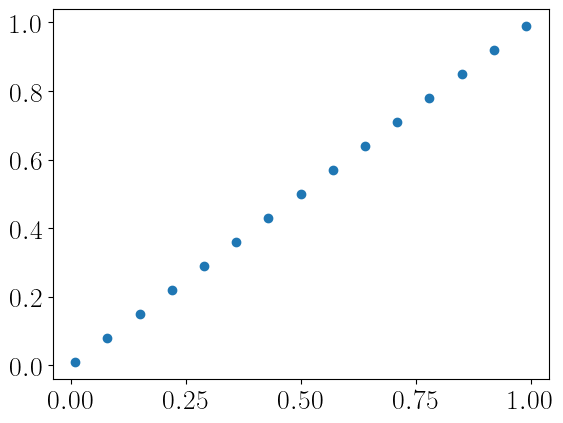

In [57]:
#channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"
channel_func = generalized_amplitude_damping_channel;
state_gen_func = generalized_amplitude_damping_channel_gen
channel_args = [0, 0]; channel_name = "ad"
dm_inp = (I + X)/2
tq = 0
state_gen_args = [dm_inp, 0, 0]

a = 0 + 0
b = 1 - 0
T = 15

eps = 1e-2
labels = linspace(a + eps, b - eps, T)#[1:-1]
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels]
dms = [state_gen_func(p, *state_gen_args) for p in labels]

plt.scatter(labels, labels)

In [58]:
n_inp = int(log2(len(dm_inp)))
method = "BFGS"
n_copies_2 = 1
n_meas_2 = n_inp*n_copies_2
n_layers_2 = 1

prior_func = lambda p: 1/(b - a); prior_args = []
# dphi = 1/sqrt(2)
# prior_func = lambda phi: exp(-(phi**2)/(2*dphi)**2)/sqrt(2*pi*dphi**2); prior_args = []

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies_2 - 1)*n_layers_2 + 2*n_inp*n_copies_2), normal(0., 1, 2**n_meas_2)])

fvals_2, result_2 = train_bayes(n_inp, n_layers_2, a, b, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, prior_args=prior_args, n_copies=n_copies_2, n_meas=n_meas_2, method=method, x0=x0, options={})
pars_2 = result_2.x

print("\n", result_2.message)

Iteration: 17 | Function value: 0.07191919
 Optimization terminated successfully.


In [59]:
fval_AD=fvals_2[-1]
print("From Inequality:           ", 178/2475)
print("From Bayes function value: ", fval_AD)

From Inequality:            0.07191919191919192
From Bayes function value:  0.07191919192650507


In [64]:
expecs_2, expecs_der_2, disps_2

(array([0.43751589, 0.44563628, 0.45385782, 0.46219329, 0.47065842,
        0.47927293, 0.4880621 , 0.4970593 , 0.50631005, 0.51587943,
        0.52586625, 0.5364343 , 0.54789463, 0.56100684, 0.57982018]),
 array([0.11533559, 0.11670054, 0.11823079, 0.11996268, 0.12194476,
        0.12424371, 0.1269541 , 0.13021538, 0.13424363, 0.1393959 ,
        0.14631573, 0.15631813, 0.17268183, 0.20735775, 0.44243975]),
 array([0.00637372, 0.00747026, 0.00844611, 0.00929747, 0.01001985,
        0.01060785, 0.0110548 , 0.01135231, 0.01148939, 0.0114511 ,
        0.01121583, 0.01074965, 0.00999165, 0.0088022 , 0.00649494]))

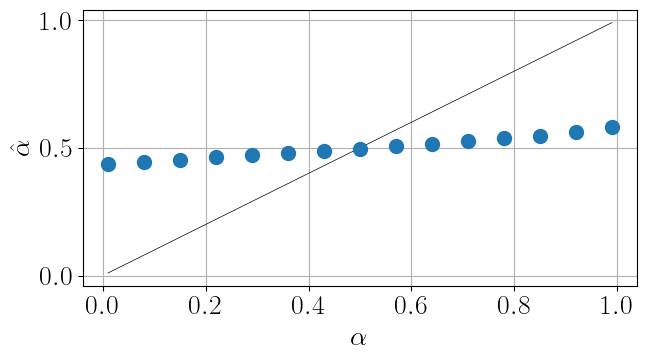

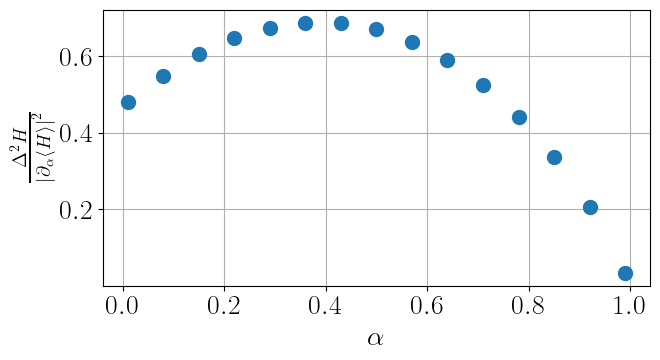

In [60]:
eps = 0.1
dp = 1e-7

expecs_2, expecs_der_2, disps_2 = aux_info_bayes(n_inp, pars_2, a+eps, b-eps, state_gen_func=state_gen_func, prior_func=prior_func, n_layers=n_layers_2, labels=labels,state_gen_args=state_gen_args, prior_args =prior_args, n_copies=n_copies_2, n_meas=n_meas_2, dp=dp)

#expecs_2, expecs_der_2, disps_2, CRB_2, QCRB_2 = aux_info_bayes(n_inp, pars_2, a+eps, b-eps, state_gen_func=state_gen_func, prior_func=prior_func, n_layers=n_layers_2, labels=labels,state_gen_args=state_gen_args, prior_args =prior_args, n_copies=n_copies_2, n_meas=n_meas_2, dp=dp)
# expecs_2, expecs_der_2, disps_2, CRB_2, QCRB_2 = aux_info(n_inp, pars_2, a+eps, b-eps, state_gen_func=state_gen_func, state_gen_args=state_gen_args, prior_func=prior_func, n_layers=n_layers_2, labels=labels, n_copies=n_copies_2, n_meas=n_meas_2, dp=dp)

# expecs_2, expecs_der_2, disps_2 = aux_info_uni_2c(pars_2, n_layers_2, labels)
# expecs_2, expecs_der_2, disps_2 = aux_info_uni_2c(pars_2, n_layers_2, labels)

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
# plt.plot(labels, expecs, zorder=10)
plt.scatter(labels, expecs_2, s=100, zorder=10)
#plt.scatter(labels, expecs_2, s=100, zorder=10)
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

#print(sum(2*disps_2/expecs_der_2**2))

plt.figure(figsize=(7, 4))
plt.scatter(labels, disps_2/expecs_der_2**2, s=100, zorder=10)
#plt.scatter(labels, 2*disps_2/expecs_der_2**2, s=100, zorder=10)
# plt.scatter(labels, disps + biass**2, s=100, zorder=10)
# plt.scatter(labels, disps, s=100, zorder=10)
#plt.plot(labels, [1]*T, color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=2)
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
# plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
# plt.yscale("log")
plt.show()

## Plot the two

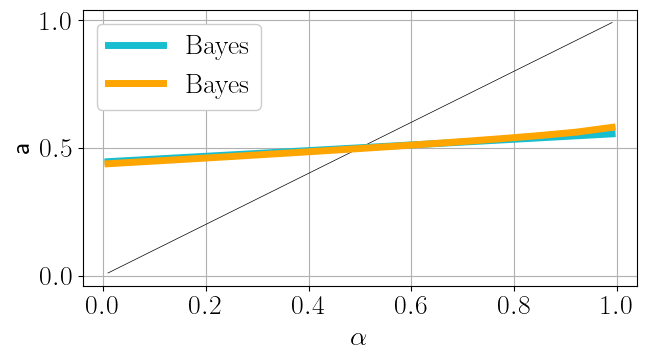

In [61]:
matplotlib.rcParams.update({'font.size': 20})

#expecs_theory
plt.figure(figsize=(7, 4))
plt.plot(labels, expecs_1, zorder=10, linewidth=5, color="tab:cyan", label="Bayes")
plt.plot(labels, expecs_2, zorder=10, linewidth=5, color="orange", label="Bayes")
# plt.plot(labels, expecs_1, zorder=10,linewidth=5, label="Bayes")
# plt.plot(labels, [trace(rho_ADI(a)@Hm_ADI(w_ls/w_var)) for a in labels_test], linestyle="dashed", label="Analytical", color="blue") ### Theory
plt.plot(labels, labels, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
#plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
#plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.legend(framealpha=1)
# plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel
# plt.yticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel

plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [ ]:



print("Sum var:", n_copies*sum(disps_test)/len(CFIs_test))
print("Sum difference:", sum(np.abs(CFIs_test - QFIs_test))/len(CFIs_test))
print("Least squares:", sum((CFIs_test - QFIs_test)**2)/len(CFIs_test))

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=20, zorder=12, color="orange")
plt.plot(labels, disps_1/expecs_der_1**2, linewidth=10, zorder=9, label="Bayes")
plt.plot(labels_test, n_copies*[disp_ADI(a, w_ls/w_var)/DrhoH_ADI(a,w_ls/w_var) for a in labels_test], color="blue", linestyle="dashed", zorder=11, label="Analytical")
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid", zorder=10) # , color="tab:blue"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
#plt.plot(np.sort(labels_test), n_copies/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
#plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1$"])
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

print("From Inequality:           ", 2/27)
print("From Bayes function value: ", 0.07407407)

### 2.4 Plotting the Final graph for Amplitude Damping channel graph

Iteration: 27 | Function value: 0.00071499
 Optimization terminated successfully.
Cost: 0.0007149875318196551

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 4.039939105099769e-08


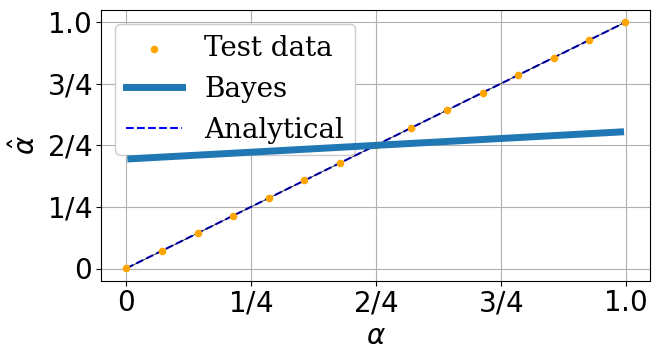

Sum var: 0.6543011594296043
Sum difference: 0.22500181240481645
Least squares: 0.7588324216407353


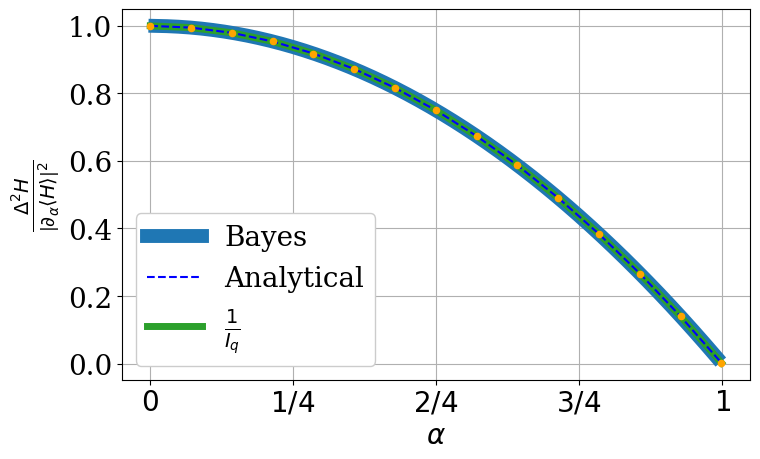

From Inequality:            0.07407407407407407
From Bayes function value:  0.07407407


In [31]:
channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"

dm_ini = eye(2)/2
a = 1e-3
b = 1 - 1e-3
labels_train = linspace(a, b, 11)#[1:-1]

dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 15)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-5

x0 = None#concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
               w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars = result.x
#print(pars)
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(channel_func, labels_train, 
                                                                               channel_args, dm_ini, pars, n_layers,
                                                                               n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, 
                                                                          channel_args, dm_ini, pars, n_layers,
                                                                          n_copies=n_copies, n_meas=n_meas, dp=dp)
print("\n", result.message)
print("Cost:", result.fun)
print("\nn_copies: %d | n_meas: %d | n_layers: %d" %(n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nSum error:", sum(np.abs(labels_test - expecs_test)**2)/len(CFIs_test))

matplotlib.rcParams.update({'font.size': 20})

#expecs_theory
plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=20, zorder=10, color="orange", label="Test data")
plt.plot(labels, expecs_1, zorder=10,linewidth=5, label="Bayes")
plt.plot(labels_test, [trace(rho_ADI(a)@Hm_ADI(w_ls/w_var)) for a in labels_test], linestyle="dashed", label="Analytical", color="blue") ### Theory
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
#plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
#plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.legend(framealpha=1)
plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel
plt.yticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1.0$"]) # for the depolarizing channel

plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


print("Sum var:", n_copies*sum(disps_test)/len(CFIs_test))
print("Sum difference:", sum(np.abs(CFIs_test - QFIs_test))/len(CFIs_test))
print("Least squares:", sum((CFIs_test - QFIs_test)**2)/len(CFIs_test))

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=20, zorder=12, color="orange")
plt.plot(labels, disps_1/expecs_der_1**2, linewidth=10, zorder=9, label="Bayes")
plt.plot(labels_test, n_copies*[disp_ADI(a, w_ls/w_var)/DrhoH_ADI(a,w_ls/w_var) for a in labels_test], color="blue", linestyle="dashed", zorder=11, label="Analytical")
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid", zorder=10) # , color="tab:blue"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
#plt.plot(np.sort(labels_test), n_copies/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
#plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.xticks([0, 1/4, 2/4, 3/4, 1.0], [r"$0$", r"$1/4$", r"$2/4$", r"$3/4$", r"$1$"])
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

print("From Inequality:           ", 2/27)
print("From Bayes function value: ", 0.07407407)

In [32]:
fval_AD

0.07407407441231073